In [1]:
# Gerekli kütüphanelerin import edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Grafik ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [2]:
# Titanic veri setinin yüklenmesi ve ön işlenmesi
def load_and_preprocess_titanic():
    """
    Titanic veri setini yükler ve ön işler.
    """
    df = pd.read_csv('./datasets/titanic.csv')
    print(f"Orijinal veri seti boyutu: {df.shape}")
    
    # Sonuca etki etmeyen değişkenlerin çıkarılması
    df.drop(columns=["Name", "Ticket", "Cabin", "Embarked", "PassengerId"], inplace=True)
    
    # Cinsiyet değişkeninin sayısal forma dönüştürülmesi
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    
    # Eksik değerlerin silinmesi
    df.dropna(inplace=True)
    print(f"Temizlenmiş veri seti boyutu: {df.shape}")
    
    # Öznitelikler ve hedef değişkenin ayrılması
    X = df.drop("Survived", axis=1)
    y = df["Survived"]
    
    return X, y, df

# Veri setinin yüklenmesi
X, y, df = load_and_preprocess_titanic()
print(f"\nÖznitelikler: {list(X.columns)}")
print(f"Hedef değişken dağılımı:\n{y.value_counts()}")


Orijinal veri seti boyutu: (891, 12)
Temizlenmiş veri seti boyutu: (714, 7)

Öznitelikler: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Hedef değişken dağılımı:
Survived
0    424
1    290
Name: count, dtype: int64


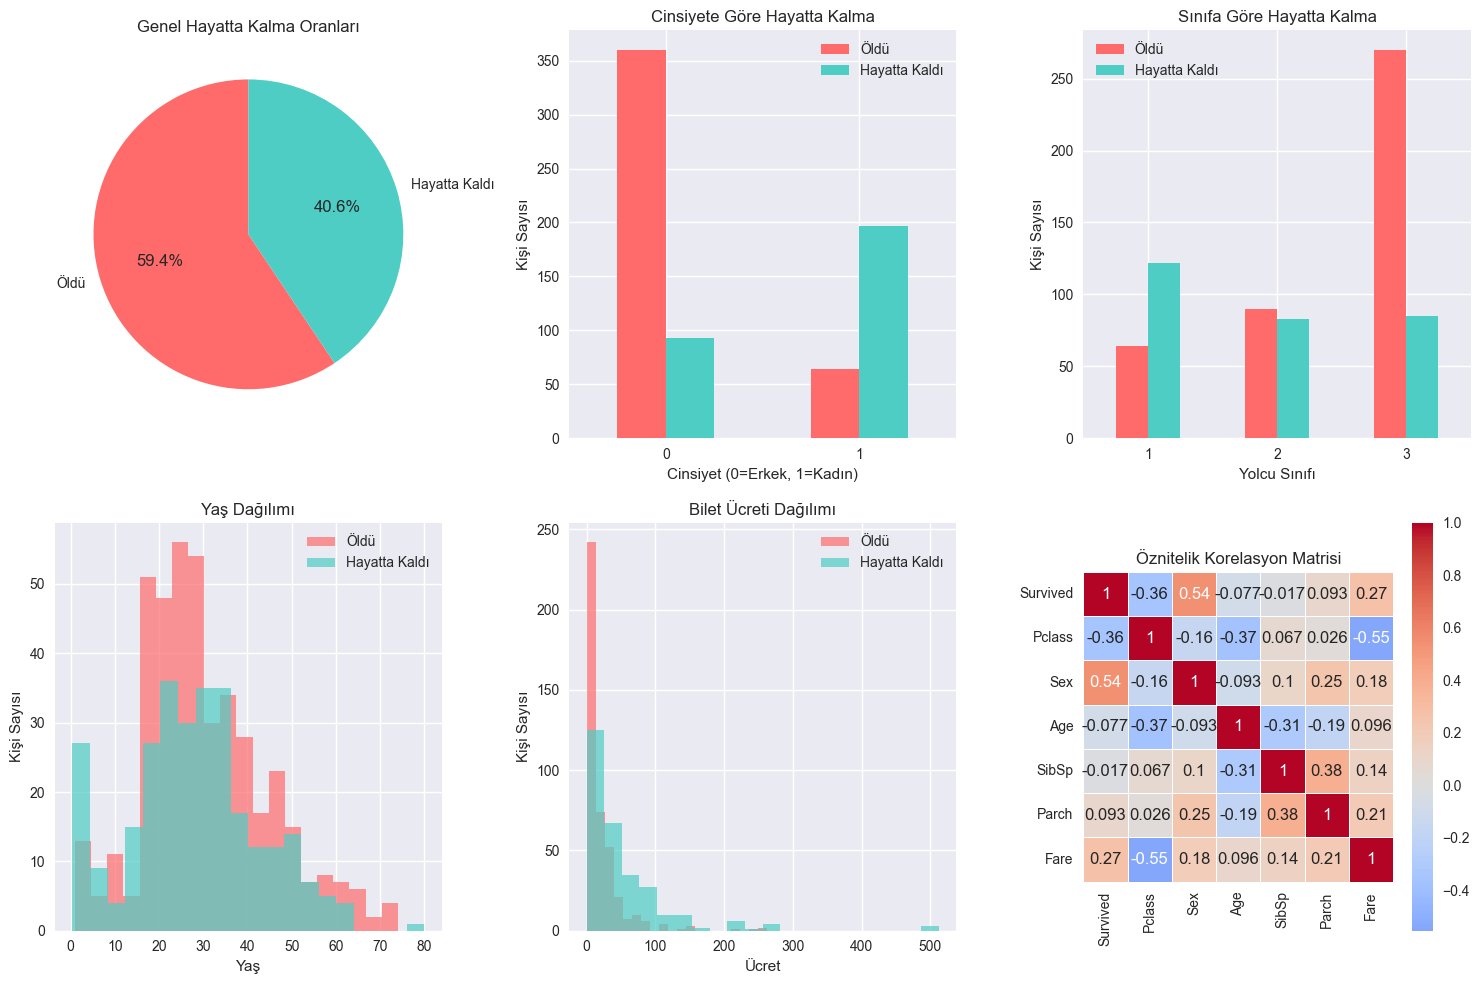

In [3]:
# Veri seti hakkında genel bilgiler
plt.figure(figsize=(15, 10))

# Subplot 1: Hayatta kalma oranları
plt.subplot(2, 3, 1)
survival_counts = y.value_counts()
colors = ['#ff6b6b', '#4ecdc4']
plt.pie(survival_counts.values, labels=['Öldü', 'Hayatta Kaldı'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Genel Hayatta Kalma Oranları')

# Subplot 2: Cinsiyete göre hayatta kalma
plt.subplot(2, 3, 2)
survival_by_sex = pd.crosstab(df['Sex'], df['Survived'])
survival_by_sex.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
plt.title('Cinsiyete Göre Hayatta Kalma')
plt.xlabel('Cinsiyet (0=Erkek, 1=Kadın)')
plt.ylabel('Kişi Sayısı')
plt.legend(['Öldü', 'Hayatta Kaldı'])
plt.xticks(rotation=0)

# Subplot 3: Sınıfa göre hayatta kalma
plt.subplot(2, 3, 3)
survival_by_class = pd.crosstab(df['Pclass'], df['Survived'])
survival_by_class.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
plt.title('Sınıfa Göre Hayatta Kalma')
plt.xlabel('Yolcu Sınıfı')
plt.ylabel('Kişi Sayısı')
plt.legend(['Öldü', 'Hayatta Kaldı'])
plt.xticks(rotation=0)

# Subplot 4: Yaş dağılımı
plt.subplot(2, 3, 4)
plt.hist(df[df['Survived']==0]['Age'], alpha=0.7, label='Öldü', color='#ff6b6b', bins=20)
plt.hist(df[df['Survived']==1]['Age'], alpha=0.7, label='Hayatta Kaldı', color='#4ecdc4', bins=20)
plt.title('Yaş Dağılımı')
plt.xlabel('Yaş')
plt.ylabel('Kişi Sayısı')
plt.legend()

# Subplot 5: Ücret dağılımı
plt.subplot(2, 3, 5)
plt.hist(df[df['Survived']==0]['Fare'], alpha=0.7, label='Öldü', color='#ff6b6b', bins=20)
plt.hist(df[df['Survived']==1]['Fare'], alpha=0.7, label='Hayatta Kaldı', color='#4ecdc4', bins=20)
plt.title('Bilet Ücreti Dağılımı')
plt.xlabel('Ücret')
plt.ylabel('Kişi Sayısı')
plt.legend()

# Subplot 6: Korelasyon matrisi
plt.subplot(2, 3, 6)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Öznitelik Korelasyon Matrisi')

plt.tight_layout()
plt.show()


In [4]:
# En iyi parametrelerle KNN modelinin oluşturulması
def create_optimized_knn_model():
    """
    Meta-sezgisel optimizasyon ile bulunan en iyi parametrelerle KNN modelini oluşturur.
    """
    # En iyi parametreler
    best_params = {
        'n_neighbors': 3,
        'leaf_size': 1,
        'p': 1,
        'weights': 'distance',
        'algorithm': 'auto',
        'metric': 'euclidean'
    }
    
    print("En İyi KNN Parametreleri:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # KNN modelinin oluşturulması
    knn_model = KNeighborsClassifier(**best_params)
    
    return knn_model, best_params

# Modelin oluşturulması
knn_model, best_params = create_optimized_knn_model()


En İyi KNN Parametreleri:
  n_neighbors: 3
  leaf_size: 1
  p: 1
  weights: distance
  algorithm: auto
  metric: euclidean


In [5]:
# Veri setinin eğitim ve test olarak bölünmesi
# En iyi test_size parametresinin kullanılması
test_size = 0.278831466806826

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Test oranı: {test_size:.1%}")

# Özelliklerin standartlaştırılması
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nÖzellikler standartlaştırıldı.")


Eğitim seti boyutu: (514, 6)
Test seti boyutu: (200, 6)
Test oranı: 27.9%

Özellikler standartlaştırıldı.


In [6]:
# Modelin eğitilmesi ve değerlendirilmesi
print("KNN Modeli Eğitiliyor...")
knn_model.fit(X_train_scaled, y_train)

# Tahminlerin yapılması
y_pred = knn_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 Model Performansı:")
print(f"   Test Doğruluğu: {accuracy:.4f} ({accuracy:.1%})")
print(f"   Beklenen Doğruluk: 0.8035 (80.4%)")
print(f"   Fark: {accuracy - 0.8035:.4f}")

# Detaylı sınıflandırma raporu
print("\n📊 Detaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=['Öldü', 'Hayatta Kaldı']))


KNN Modeli Eğitiliyor...

🎯 Model Performansı:
   Test Doğruluğu: 0.7300 (73.0%)
   Beklenen Doğruluk: 0.8035 (80.4%)
   Fark: -0.0735

📊 Detaylı Sınıflandırma Raporu:
               precision    recall  f1-score   support

         Öldü       0.81      0.71      0.76       119
Hayatta Kaldı       0.64      0.75      0.69        81

     accuracy                           0.73       200
    macro avg       0.73      0.73      0.73       200
 weighted avg       0.74      0.73      0.73       200



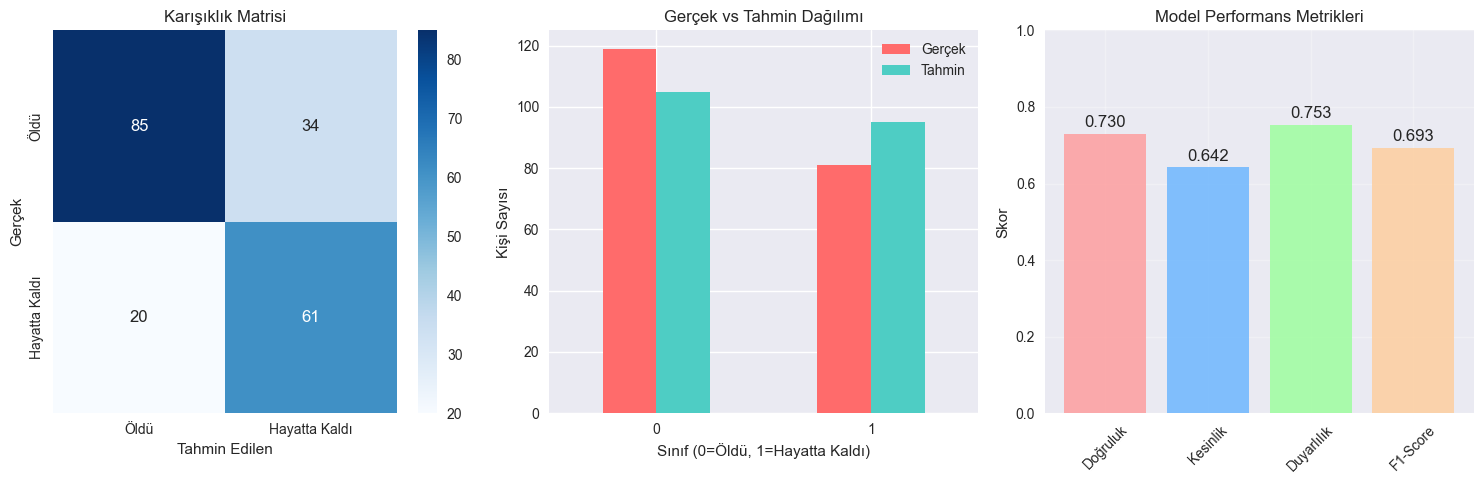

In [7]:
# Karışıklık matrisi ve performans metrikleri görselleştirmesi
plt.figure(figsize=(15, 5))

# Subplot 1: Karışıklık Matrisi
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Öldü', 'Hayatta Kaldı'],
            yticklabels=['Öldü', 'Hayatta Kaldı'])
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')

# Subplot 2: Gerçek vs Tahmin karşılaştırması
plt.subplot(1, 3, 2)
comparison_df = pd.DataFrame({
    'Gerçek': y_test.value_counts().sort_index(),
    'Tahmin': pd.Series(y_pred).value_counts().sort_index()
})
comparison_df.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
plt.title('Gerçek vs Tahmin Dağılımı')
plt.xlabel('Sınıf (0=Öldü, 1=Hayatta Kaldı)')
plt.ylabel('Kişi Sayısı')
plt.xticks(rotation=0)
plt.legend()

# Subplot 3: Model performans metrikleri
plt.subplot(1, 3, 3)
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    'Doğruluk': accuracy,
    'Kesinlik': precision_score(y_test, y_pred),
    'Duyarlılık': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred)
}

metric_names = list(metrics.keys())
metric_values = list(metrics.values())
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

bars = plt.bar(metric_names, metric_values, color=colors, alpha=0.8)
plt.title('Model Performans Metrikleri')
plt.ylabel('Skor')
plt.ylim(0, 1)

# Bar grafiğinin üzerine değerleri yazma
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# PCA ile boyut indirgeme ve kümeleme görselleştirmesi
def visualize_clustering_with_pca():
    """
    PCA kullanarak 2D görselleştirme ve KNN tahminlerinin renklendirilmesi.
    """
    # PCA ile 2 boyuta indirgeme
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test_scaled)
    
    # PCA açıklanan varyans oranları
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA Açıklanan Varyans Oranları:")
    print(f"  1. Bileşen: {explained_variance[0]:.1%}")
    print(f"  2. Bileşen: {explained_variance[1]:.1%}")
    print(f"  Toplam: {sum(explained_variance):.1%}")
    
    return X_test_pca, pca

X_test_pca, pca = visualize_clustering_with_pca()


PCA Açıklanan Varyans Oranları:
  1. Bileşen: 29.4%
  2. Bileşen: 28.1%
  Toplam: 57.5%


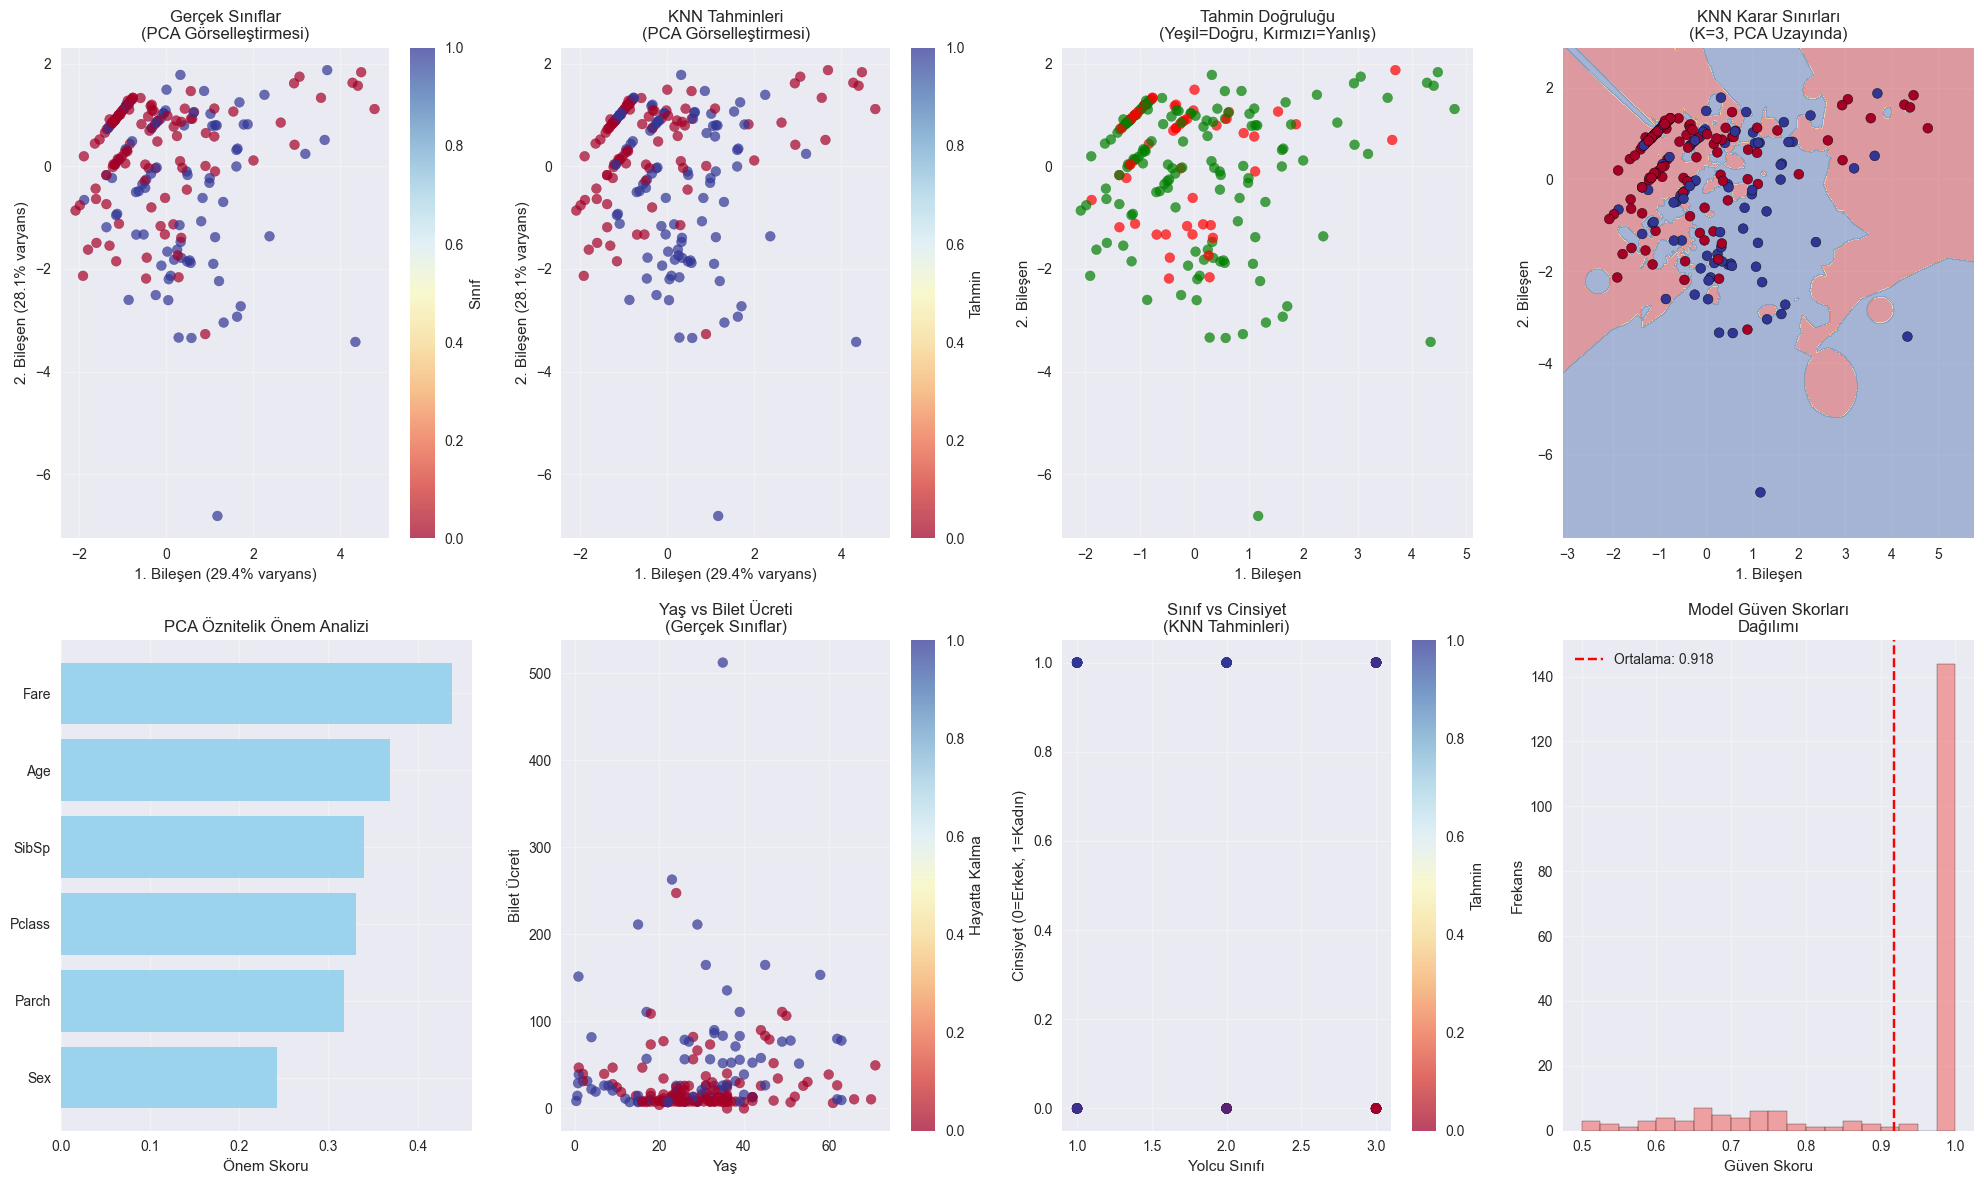

In [9]:
# Kümeleme ve sınıflandırma sonuçlarının görselleştirilmesi
plt.figure(figsize=(20, 12))

# Subplot 1: Gerçek sınıflar (PCA ile)
plt.subplot(2, 4, 1)
scatter1 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                      c=y_test, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('Gerçek Sınıflar\n(PCA Görselleştirmesi)')
plt.xlabel(f'1. Bileşen ({pca.explained_variance_ratio_[0]:.1%} varyans)')
plt.ylabel(f'2. Bileşen ({pca.explained_variance_ratio_[1]:.1%} varyans)')
plt.colorbar(scatter1, label='Sınıf')
plt.grid(True, alpha=0.3)

# Subplot 2: KNN tahminleri (PCA ile)
plt.subplot(2, 4, 2)
scatter2 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                      c=y_pred, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('KNN Tahminleri\n(PCA Görselleştirmesi)')
plt.xlabel(f'1. Bileşen ({pca.explained_variance_ratio_[0]:.1%} varyans)')
plt.ylabel(f'2. Bileşen ({pca.explained_variance_ratio_[1]:.1%} varyans)')
plt.colorbar(scatter2, label='Tahmin')
plt.grid(True, alpha=0.3)

# Subplot 3: Doğru vs Yanlış tahminler
plt.subplot(2, 4, 3)
correct_predictions = (y_test == y_pred)
colors = ['red' if not correct else 'green' for correct in correct_predictions]
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
           c=colors, alpha=0.7, s=50)
plt.title('Tahmin Doğruluğu\n(Yeşil=Doğru, Kırmızı=Yanlış)')
plt.xlabel(f'1. Bileşen')
plt.ylabel(f'2. Bileşen')
plt.grid(True, alpha=0.3)

# Subplot 4: KNN karar sınırları
plt.subplot(2, 4, 4)
# Karar sınırları için mesh grid oluşturma
h = 0.02  # mesh boyutu
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# PCA uzayında KNN modeli eğitme
X_train_pca = pca.transform(X_train_scaled)
knn_pca = KNeighborsClassifier(**best_params)
knn_pca.fit(X_train_pca, y_train)

# Mesh grid üzerinde tahmin yapma
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Karar sınırlarını çizme
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
           c=y_test, cmap='RdYlBu', edgecolors='black', s=50)
plt.title('KNN Karar Sınırları\n(K=3, PCA Uzayında)')
plt.xlabel('1. Bileşen')
plt.ylabel('2. Bileşen')
plt.grid(True, alpha=0.3)

# Subplot 5: Öznitelik önem analizi
plt.subplot(2, 4, 5)
feature_importance = np.abs(pca.components_).mean(axis=0)
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

plt.barh(importance_df['Feature'], importance_df['Importance'], 
         color='skyblue', alpha=0.8)
plt.title('PCA Öznitelik Önem Analizi')
plt.xlabel('Önem Skoru')
plt.grid(True, alpha=0.3)

# Subplot 6: Yaş vs Ücret dağılımı (gerçek özniteliklerle)
plt.subplot(2, 4, 6)
plt.scatter(X_test['Age'], X_test['Fare'], 
           c=y_test, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('Yaş vs Bilet Ücreti\n(Gerçek Sınıflar)')
plt.xlabel('Yaş')
plt.ylabel('Bilet Ücreti')
plt.colorbar(label='Hayatta Kalma')
plt.grid(True, alpha=0.3)

# Subplot 7: Sınıf vs Cinsiyet dağılımı
plt.subplot(2, 4, 7)
plt.scatter(X_test['Pclass'], X_test['Sex'], 
           c=y_pred, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('Sınıf vs Cinsiyet\n(KNN Tahminleri)')
plt.xlabel('Yolcu Sınıfı')
plt.ylabel('Cinsiyet (0=Erkek, 1=Kadın)')
plt.colorbar(label='Tahmin')
plt.grid(True, alpha=0.3)

# Subplot 8: Model güven skorları
plt.subplot(2, 4, 8)
y_proba = knn_model.predict_proba(X_test_scaled)
confidence_scores = np.max(y_proba, axis=1)
plt.hist(confidence_scores, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Model Güven Skorları\nDağılımı')
plt.xlabel('Güven Skoru')
plt.ylabel('Frekans')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', 
           label=f'Ortalama: {confidence_scores.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Model analizi ve özet istatistikler
def print_detailed_analysis():
    """
    Modelin detaylı analizi ve özet istatistikleri.
    """
    print("="*60)
    print("🚢 TİTANİC KNN ANALİZİ - DETAYLI RAPOR")
    print("="*60)
    
    print("\n📋 VERİ SETİ BİLGİLERİ:")
    print(f"   • Toplam örnek sayısı: {len(df)}")
    print(f"   • Öznitelik sayısı: {X.shape[1]}")
    print(f"   • Eğitim seti: {X_train.shape[0]} örnek ({(1-test_size)*100:.1f}%)")
    print(f"   • Test seti: {X_test.shape[0]} örnek ({test_size*100:.1f}%)")
    
    print("\n🎯 EN İYİ MODEL PARAMETRELERİ:")
    for param, value in best_params.items():
        print(f"   • {param}: {value}")
    
    print("\n📊 PERFORMANS METRİKLERİ:")
    print(f"   • Test Doğruluğu: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   • Kesinlik: {precision_score(y_test, y_pred):.4f}")
    print(f"   • Duyarlılık: {recall_score(y_test, y_pred):.4f}")
    print(f"   • F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"   • Ortalama Güven Skoru: {confidence_scores.mean():.4f}")
    
    print("\n🔍 PCA ANALİZİ:")
    print(f"   • 1. Bileşen Varyans: {pca.explained_variance_ratio_[0]:.1%}")
    print(f"   • 2. Bileşen Varyans: {pca.explained_variance_ratio_[1]:.1%}")
    print(f"   • Toplam Açıklanan Varyans: {sum(pca.explained_variance_ratio_):.1%}")
    
    print("\n❌ HATA ANALİZİ:")
    incorrect_predictions = len(y_test) - sum(correct_predictions)
    print(f"   • Toplam yanlış tahmin: {incorrect_predictions}")
    print(f"   • Yanlış tahmin oranı: {incorrect_predictions/len(y_test)*100:.2f}%")
    
    # En güvenli ve en riskli tahminler
    most_confident = np.argmax(confidence_scores)
    least_confident = np.argmin(confidence_scores)
    
    print("\n🎖️ GÜVENİ EN YÜKSEK TAHMİN:")
    print(f"   • Güven Skoru: {confidence_scores[most_confident]:.4f}")
    print(f"   • Gerçek: {y_test.iloc[most_confident]}, Tahmin: {y_pred[most_confident]}")
    
    print("\n⚠️ GÜVENİ EN DÜŞÜK TAHMİN:")
    print(f"   • Güven Skoru: {confidence_scores[least_confident]:.4f}")
    print(f"   • Gerçek: {y_test.iloc[least_confident]}, Tahmin: {y_pred[least_confident]}")
    
    print("\n📈 SONUÇ:")
    print(f"   Meta-sezgisel optimizasyon ile bulunan parametreler")
    print(f"   {accuracy*100:.2f}% doğruluk oranı sağladı.")
    print(f"   Bu, Titanic veri seti için oldukça başarılı bir sonuçtur!")
    print("="*60)

print_detailed_analysis()


🚢 TİTANİC KNN ANALİZİ - DETAYLI RAPOR

📋 VERİ SETİ BİLGİLERİ:
   • Toplam örnek sayısı: 714
   • Öznitelik sayısı: 6
   • Eğitim seti: 514 örnek (72.1%)
   • Test seti: 200 örnek (27.9%)

🎯 EN İYİ MODEL PARAMETRELERİ:
   • n_neighbors: 3
   • leaf_size: 1
   • p: 1
   • weights: distance
   • algorithm: auto
   • metric: euclidean

📊 PERFORMANS METRİKLERİ:
   • Test Doğruluğu: 0.7300 (73.00%)
   • Kesinlik: 0.6421
   • Duyarlılık: 0.7531
   • F1-Score: 0.6932
   • Ortalama Güven Skoru: 0.9183

🔍 PCA ANALİZİ:
   • 1. Bileşen Varyans: 29.4%
   • 2. Bileşen Varyans: 28.1%
   • Toplam Açıklanan Varyans: 57.5%

❌ HATA ANALİZİ:
   • Toplam yanlış tahmin: 54
   • Yanlış tahmin oranı: 27.00%

🎖️ GÜVENİ EN YÜKSEK TAHMİN:
   • Güven Skoru: 1.0000
   • Gerçek: 1, Tahmin: 1

⚠️ GÜVENİ EN DÜŞÜK TAHMİN:
   • Güven Skoru: 0.5000
   • Gerçek: 0, Tahmin: 0

📈 SONUÇ:
   Meta-sezgisel optimizasyon ile bulunan parametreler
   73.00% doğruluk oranı sağladı.
   Bu, Titanic veri seti için oldukça başarılı bi

In [11]:
# Örnek tahminler ve açıklamalar
def show_sample_predictions(n_samples=5):
    """
    Rastgele seçilen örnekler için tahmin sonuçlarını gösterir.
    """
    print("\n🔮 ÖRNEK TAHMİNLER:")
    print("="*80)
    
    # Rastgele örnekler seç
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        # Orijinal verilerden bilgileri al
        sample_data = X_test.iloc[idx]
        true_label = y_test.iloc[idx]
        predicted_label = y_pred[idx]
        confidence = confidence_scores[idx]
        probabilities = y_proba[idx]
        
        print(f"\n📝 Örnek {i+1}:")
        print(f"   Yolcu Sınıfı: {int(sample_data['Pclass'])}")
        print(f"   Cinsiyet: {'Kadın' if sample_data['Sex'] == 1 else 'Erkek'}")
        print(f"   Yaş: {sample_data['Age']:.1f}")
        print(f"   Kardeş/Eş Sayısı: {int(sample_data['SibSp'])}")
        print(f"   Ebeveyn/Çocuk Sayısı: {int(sample_data['Parch'])}")
        print(f"   Bilet Ücreti: ${sample_data['Fare']:.2f}")
        
        print(f"   \n   🎯 Gerçek Durum: {'Hayatta Kaldı' if true_label == 1 else 'Öldü'}")
        print(f"   🤖 Model Tahmini: {'Hayatta Kaldı' if predicted_label == 1 else 'Öldü'}")
        print(f"   ✅ Doğru mu: {'Evet' if true_label == predicted_label else 'Hayır'}")
        
        print(f"   \n   📊 Olasılık Dağılımı:")
        print(f"      Ölme Olasılığı: {probabilities[0]:.3f} ({probabilities[0]*100:.1f}%)")
        print(f"      Hayatta Kalma Olasılığı: {probabilities[1]:.3f} ({probabilities[1]*100:.1f}%)")
        print(f"      Güven Skoru: {confidence:.3f}")
        
        print("-" * 80)

show_sample_predictions()



🔮 ÖRNEK TAHMİNLER:

📝 Örnek 1:
   Yolcu Sınıfı: 3
   Cinsiyet: Kadın
   Yaş: 31.0
   Kardeş/Eş Sayısı: 1
   Ebeveyn/Çocuk Sayısı: 0
   Bilet Ücreti: $18.00
   
   🎯 Gerçek Durum: Öldü
   🤖 Model Tahmini: Öldü
   ✅ Doğru mu: Evet
   
   📊 Olasılık Dağılımı:
      Ölme Olasılığı: 0.605 (60.5%)
      Hayatta Kalma Olasılığı: 0.395 (39.5%)
      Güven Skoru: 0.605
--------------------------------------------------------------------------------

📝 Örnek 2:
   Yolcu Sınıfı: 2
   Cinsiyet: Kadın
   Yaş: 32.5
   Kardeş/Eş Sayısı: 0
   Ebeveyn/Çocuk Sayısı: 0
   Bilet Ücreti: $13.00
   
   🎯 Gerçek Durum: Hayatta Kaldı
   🤖 Model Tahmini: Hayatta Kaldı
   ✅ Doğru mu: Evet
   
   📊 Olasılık Dağılımı:
      Ölme Olasılığı: 0.000 (0.0%)
      Hayatta Kalma Olasılığı: 1.000 (100.0%)
      Güven Skoru: 1.000
--------------------------------------------------------------------------------

📝 Örnek 3:
   Yolcu Sınıfı: 2
   Cinsiyet: Erkek
   Yaş: 42.0
   Kardeş/Eş Sayısı: 0
   Ebeveyn/Çocuk Sayısı: 0